Notebook 4.0-data-modeling.ipynb:

- Mục đích: Xây dựng và đánh giá các mô hình học máy (regression và classification) cho dữ liệu 
  về phát thải khí nhà kính và CO₂. 
- Dữ liệu: Sử dụng file cleaned_data.csv đã tiền xử lý từ những Notebook trước.
- Nội dung chính:
  1. Chuẩn bị dữ liệu (train-test split, xử lý đặc trưng, scaling).
  2. Triển khai loạt mô hình Regression (Linear Regression, Decision Tree, Random Forest, 
     Gradient Boosting, XGBoost, LightGBM, SVR) để dự đoán CO₂ trên đầu người (CO2_pc).
  3. Đánh giá các mô hình Regression qua các chỉ số: RMSE, MAE, R².
  4. Chuyển đổi CO2_pc thành ba nhóm (Low, Medium, High), xây dựng mô hình Classification 
     (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, SVM).
  5. Đánh giá các mô hình Classification qua độ chính xác (Accuracy), Confusion Matrix, 
     Precision, Recall, F1-score.
  6. Tổng hợp kết quả, so sánh mô hình để tìm ra phương án tối ưu cho bài toán.

In [25]:
# ==============================
# Cell 1: Import Libraries
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, SVC
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler


Trong cell tiếp theo, chúng ta sẽ:
1. Đọc dữ liệu từ cleaned_data.csv.
2. In kích thước tập dữ liệu (số hàng, số cột).
3. Gọi hàm info() để xem thông tin về các cột, kiểu dữ liệu.
4. Xem qua vài dòng đầu để hình dung về cấu trúc dữ liệu.


In [26]:
# ==============================
# Cell 2: Load and Inspect Data
# ==============================

# Load the same 'cleaned_data.csv' used in the previous notebooks
df = pd.read_csv('cleaned_data.csv')

print("Shape of the dataset:", df.shape)
df.info()

# Quick preview of the data
df.head()


Shape of the dataset: (2795, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         2795 non-null   object 
 1   Year            2795 non-null   int64  
 2   CO2_pc          2795 non-null   float64
 3   CO2_share       2795 non-null   float64
 4   GHG_annual      2795 non-null   float64
 5   CO2_cumulative  2795 non-null   int64  
 6   N2O_annual      2795 non-null   float64
 7   CH4_annual      2795 non-null   float64
 8   CO2_coal        2795 non-null   float64
 9   CO2_oil         2795 non-null   float64
 10  CO2_gas         2795 non-null   float64
 11  CO2_flaring     2795 non-null   float64
 12  CO2_transport   2795 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 284.0+ KB


,Country,Year,CO2_pc,CO2_share,GHG_annual,CO2_cumulative,N2O_annual,CH4_annual,CO2_coal,CO2_oil,CO2_gas,CO2_flaring,CO2_transport
0,Afghanistan,2010,0.296733,0.025115,31517414.0,103516320,4313534.5,17632924.0,2246032.0,5833088.0,271136.0,0.0,5540000.0
1,Afghanistan,2011,0.404740,0.034377,35598764.0,115354630,4477510.5,18206366.0,4180624.0,7335328.0,307776.0,0.0,6710000.0
2,Afghanistan,2012,0.329389,0.028725,33642076.0,125389950,4489223.0,18100962.0,3125392.0,6573216.0,307776.0,0.0,5850000.0
3,Afghanistan,2013,0.293283,0.026256,32901880.0,134640460,4488093.0,18211250.0,3326912.0,5591264.0,296784.0,0.0,4330000.0
4,Afghanistan,2014,0.280299,0.025856,33513274.0,143810770,4753052.0,18687494.0,3705783.0,5164638.0,271244.0,0.0,3530000.0


Trong cell sau:
- Tạo heatmap để trực quan hoá giá trị thiếu (nếu có).
- Điền các giá trị thiếu cho các cột numeric bằng median.


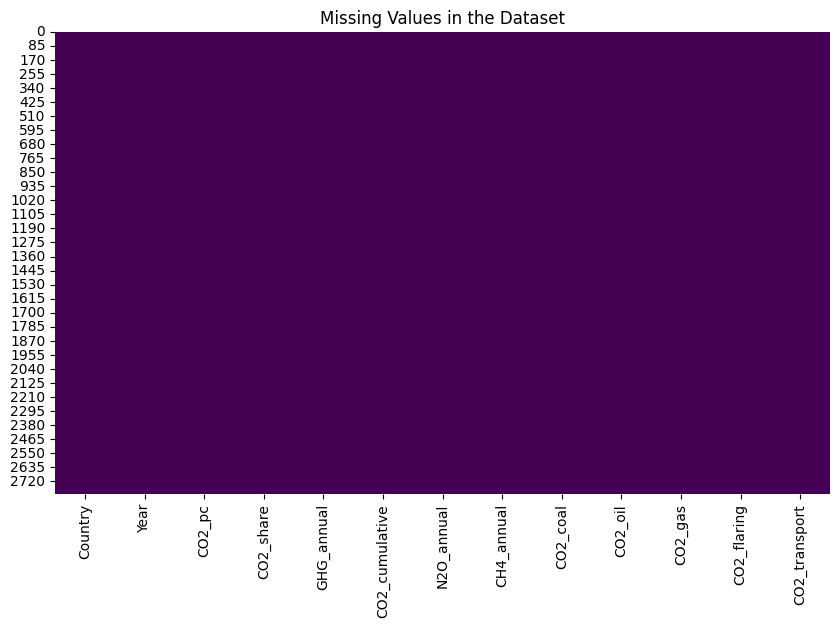

Missing values filled with median for numeric columns (if any were present).


In [27]:
# =====================================
# Cell 3: Check & Handle Missing Values
# =====================================

# Visualize missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in the Dataset")
plt.show()

# Fill missing numeric columns with median, if any
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("Missing values filled with median for numeric columns (if any were present).")


Trong cell tới:
1. Ta sẽ tính ma trận tương quan chỉ trên các cột numeric.
2. Trực quan hoá ma trận tương quan bằng heatmap.
3. Quyết định chọn một số cột làm features dựa trên mức độ liên quan đến 'CO2_pc'.


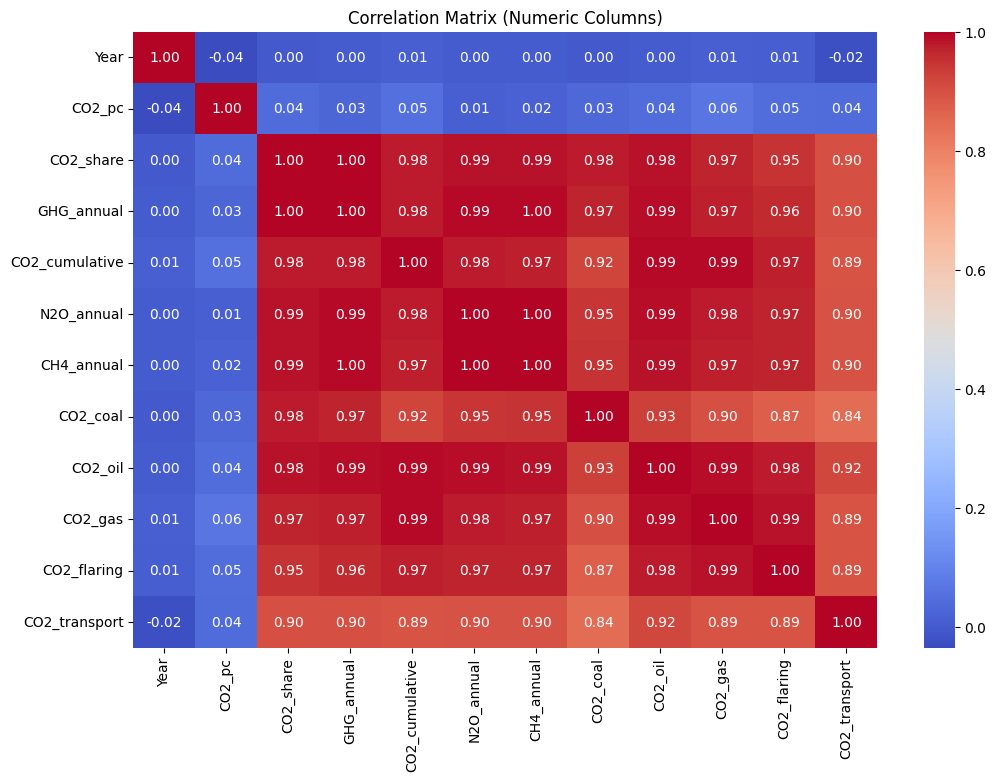

In [28]:
# ======================================
# Cell 4: Correlation & Feature Analysis
# ======================================

# To keep the modeling consistent, we'll pick 'CO2_pc' as the target for regression
# We'll explore potential features among the numeric columns, excluding 'Year' if it doesn't make sense as a numeric predictor.
# You may adapt feature selection based on correlation or domain knowledge.

# Show correlation heatmap to guide feature selection
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Columns)")
plt.show()


# We'll pick some features that correlate with CO2_pc (CO₂ per capita).
# For example: GHG_annual, CO2_cumulative, N2O_annual, CH4_annual, CO2_coal, CO2_oil, CO2_gas, CO2_flaring, CO2_transport

# Adjust the list below as needed, based on correlation or domain expertise
feature_columns = [
    'GHG_annual',
    'CO2_cumulative',
    'N2O_annual',
    'CH4_annual',
    'CO2_coal',
    'CO2_oil',
    'CO2_gas',
    'CO2_flaring',
    'CO2_transport'
]

target_variable = 'CO2_pc'


Trong cell sau, chúng ta:
1. Tạo biến X (features) từ `feature_columns`.
2. Tạo biến y (target) từ `CO2_pc`.
3. Xem nhanh phân phối của y để biết dữ liệu mục tiêu có bị lệch hay không.


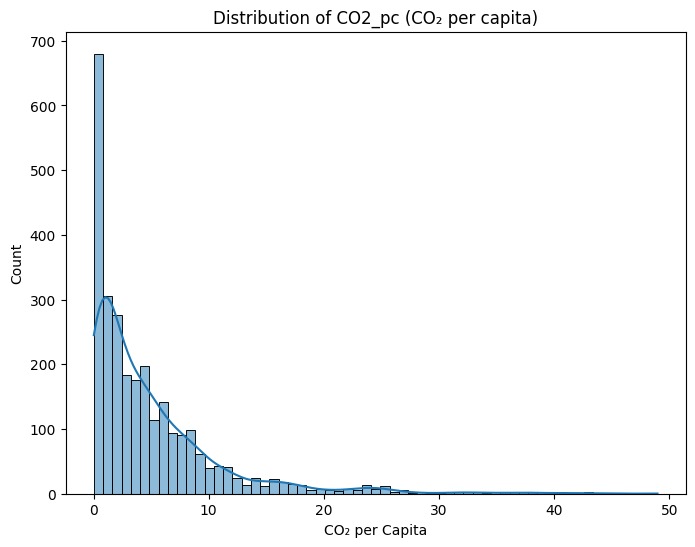

In [29]:
# ==============================
# Cell 5: Define X and y
# ==============================

# Define features (X) and target (y) for regression
X = df[feature_columns].copy()
y = df[target_variable].copy()

# Check the distribution of the target
plt.figure(figsize=(8,6))
sns.histplot(y, kde=True)
plt.title("Distribution of CO2_pc (CO₂ per capita)")
plt.xlabel("CO₂ per Capita")
plt.show()


Trong cell tới:
1. Chia dữ liệu thành train/test (80/20).
2. Dùng StandardScaler để chuẩn hoá các cột numeric của X.
3. Đảm bảo mô hình làm việc tốt hơn với các giá trị có khác biệt lớn về scale.


In [30]:
# =================================
# Cell 6: Train/Test Split & Scaling
# =================================

# Split data into train and test sets (80% - 20% split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaling complete. Ready for modeling.")


Data scaling complete. Ready for modeling.


Dùng LinearRegression (hồi quy tuyến tính):
1. Huấn luyện trên X_train_scaled, y_train.
2. Dự đoán trên X_test_scaled.
3. Tính các chỉ số RMSE, MAE, R².
4. Vẽ biểu đồ Actual vs Predicted.


=== Linear Regression Results ===
RMSE: 5.4548, MAE: 3.7971, R2: 0.1138


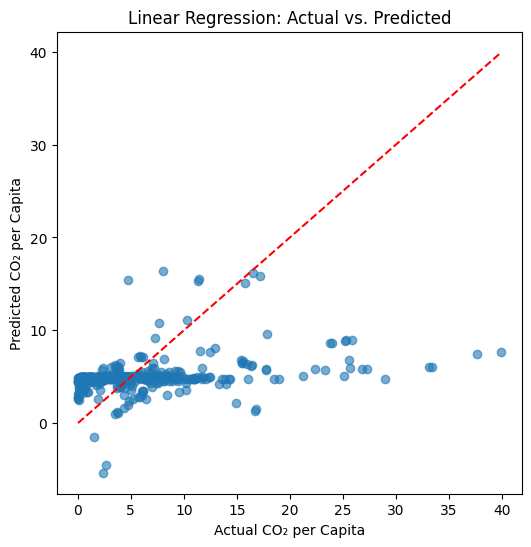

In [31]:
# ====================================
# Cell 7: Model 1 - Linear Regression
# ====================================

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("=== Linear Regression Results ===")
print(f"RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("Linear Regression: Actual vs. Predicted")
plt.show()


Dùng DecisionTreeRegressor:
1. Huấn luyện model.
2. Tính RMSE, MAE, R².
3. Trực quan hoá feature importances.


=== Decision Tree Regressor Results ===
RMSE: 0.8720, MAE: 0.3087, R2: 0.9774


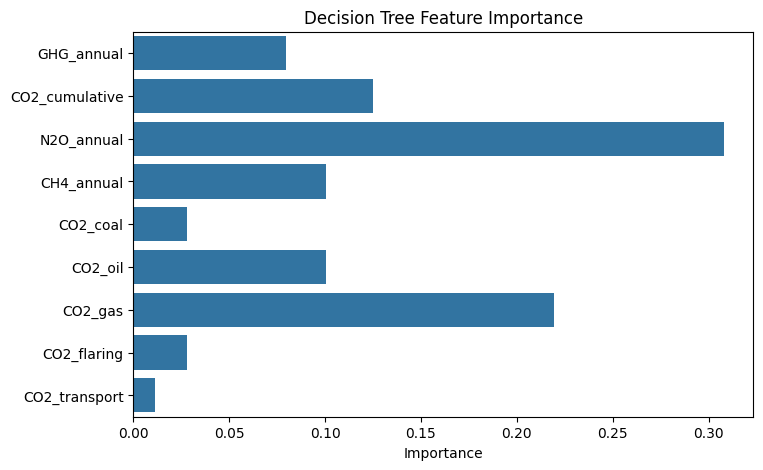

In [32]:
# ======================================
# Cell 8: Model 2 - Decision Tree Regressor
# ======================================

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("=== Decision Tree Regressor Results ===")
print(f"RMSE: {rmse_dt:.4f}, MAE: {mae_dt:.4f}, R2: {r2_dt:.4f}")

# Feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=dt.feature_importances_, y=feature_columns)
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance")
plt.show()


Sử dụng RandomForestRegressor:
1. Huấn luyện model.
2. Tính RMSE, MAE, R².
3. Vẽ feature importances.
4. Vẽ biểu đồ Actual vs Predicted.


=== Random Forest Regressor Results ===
RMSE: 0.8446, MAE: 0.4100, R2: 0.9788


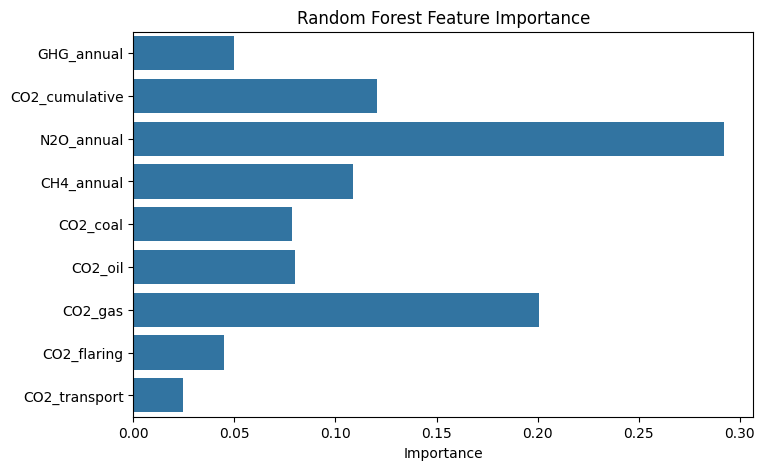

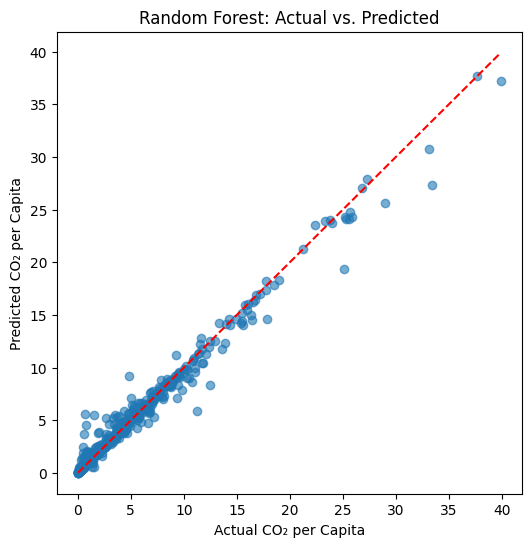

In [33]:
# =======================================
# Cell 9: Model 3 - Random Forest Regressor
# =======================================

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Random Forest Regressor Results ===")
print(f"RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")

# Feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=rf.feature_importances_, y=feature_columns)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("Random Forest: Actual vs. Predicted")
plt.show()


Dùng GradientBoostingRegressor:
1. Huấn luyện.
2. Tính RMSE, MAE, R².
3. Xem feature importances, so sánh Actual vs Predicted.


=== Gradient Boosting Regressor Results ===
RMSE: 2.0034, MAE: 1.4024, R2: 0.8805


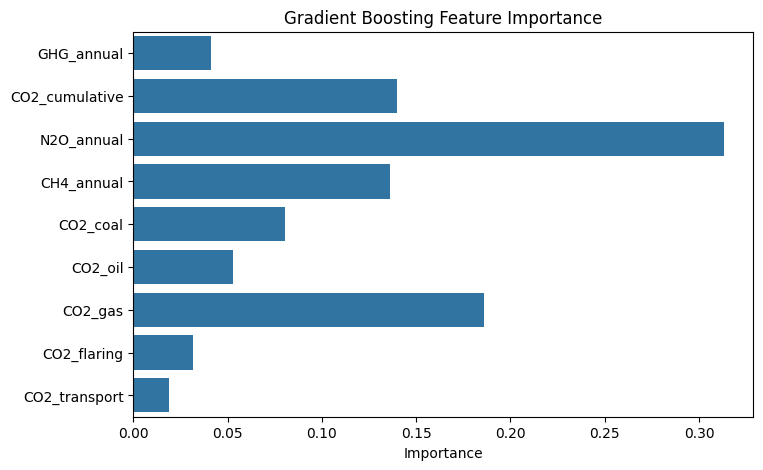

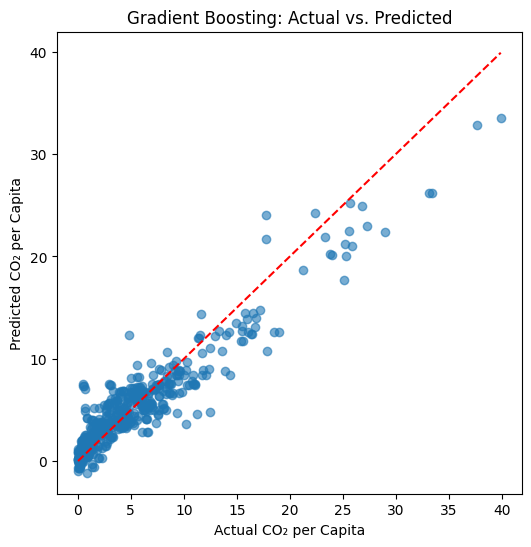

In [34]:
# =========================================
# Cell 10: Model 4 - Gradient Boosting Regressor
# =========================================

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("=== Gradient Boosting Regressor Results ===")
print(f"RMSE: {rmse_gb:.4f}, MAE: {mae_gb:.4f}, R2: {r2_gb:.4f}")

plt.figure(figsize=(8,5))
sns.barplot(x=gb.feature_importances_, y=feature_columns)
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance")
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_gb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("Gradient Boosting: Actual vs. Predicted")
plt.show()


Dùng XGBRegressor:
1. Huấn luyện với eval_metric = 'rmse'.
2. Tính RMSE, MAE, R².
3. Vẽ feature importances và biểu đồ Actual vs Predicted.


=== XGBoost Regressor Results ===
RMSE: 1.1044, MAE: 0.5049, R2: 0.9637


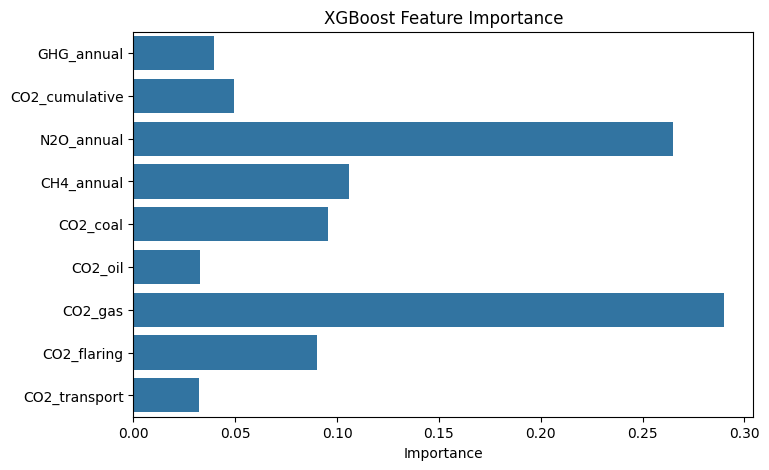

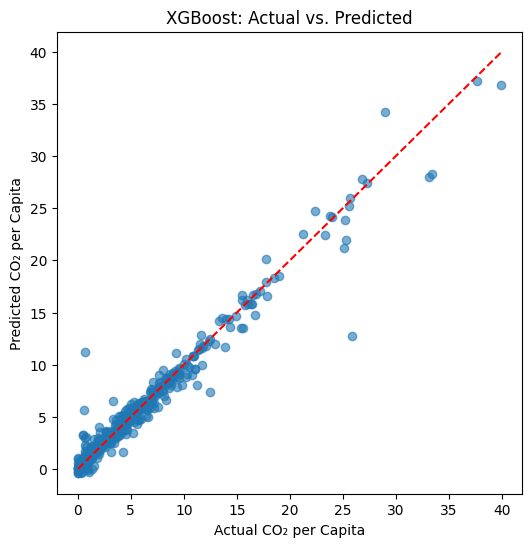

In [35]:
# =========================================
# Cell 11: Model 5 - XGBoost Regressor
# =========================================

xgb = XGBRegressor(random_state=42, eval_metric='rmse')
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("=== XGBoost Regressor Results ===")
print(f"RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}")

plt.figure(figsize=(8,5))
sns.barplot(x=xgb.feature_importances_, y=feature_columns)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("XGBoost: Actual vs. Predicted")
plt.show()


Dùng LGBMRegressor:
1. Huấn luyện.
2. Tính RMSE, MAE, R².
3. Vẽ feature importances, biểu đồ Actual vs Predicted.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2236, number of used features: 9
[LightGBM] [Info] Start training from score 4.912452
=== LightGBM Regressor Results ===
RMSE: 1.2322, MAE: 0.7126, R2: 0.9548


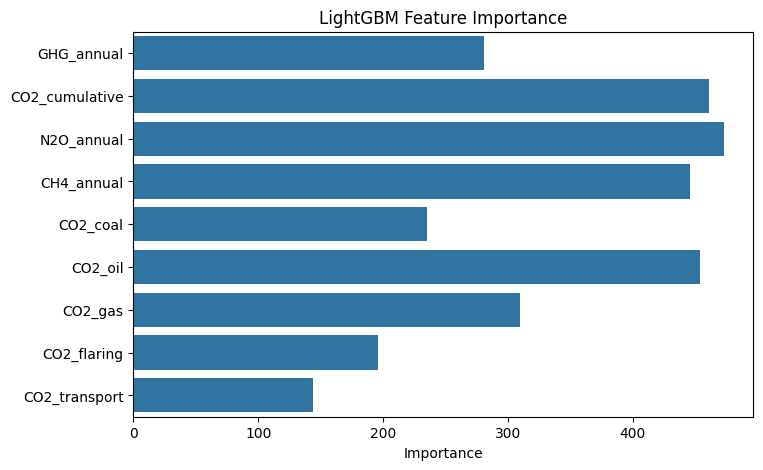

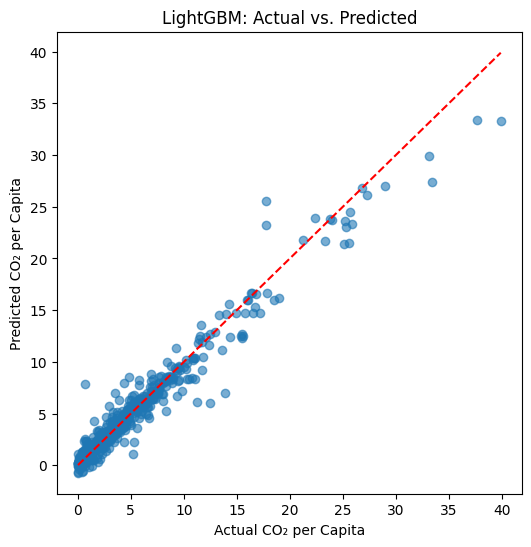

In [36]:
# =========================================
# Cell 12: Model 6 - LightGBM Regressor
# =========================================

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("=== LightGBM Regressor Results ===")
print(f"RMSE: {rmse_lgbm:.4f}, MAE: {mae_lgbm:.4f}, R2: {r2_lgbm:.4f}")

plt.figure(figsize=(8,5))
sns.barplot(x=lgbm.feature_importances_, y=feature_columns)
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("LightGBM: Actual vs. Predicted")
plt.show()


Dùng SVR:
1. Huấn luyện trên dữ liệu đã scale.
2. Tính toán RMSE, MAE, R².
3. So sánh thực tế và dự đoán.


=== SVR Results ===
RMSE: 5.7747, MAE: 3.3305, R2: 0.0068


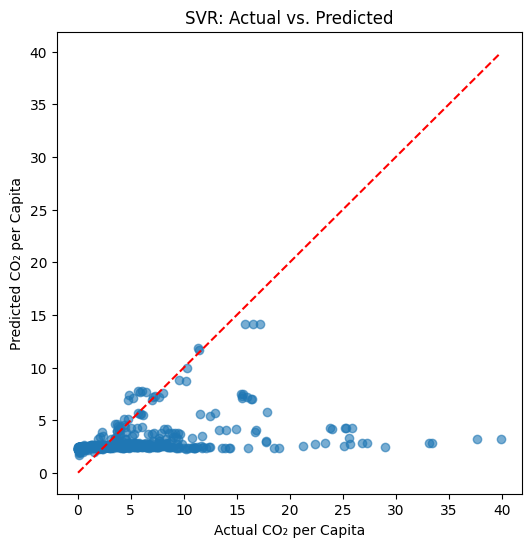

In [37]:
# =====================================
# Cell 13: Model 7 - Support Vector Regressor
# =====================================

svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("=== SVR Results ===")
print(f"RMSE: {rmse_svr:.4f}, MAE: {mae_svr:.4f}, R2: {r2_svr:.4f}")

# Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("SVR: Actual vs. Predicted")
plt.show()


Trong cell tới:
1. Tạo dataframe so sánh (RMSE, MAE, R²) giữa tất cả mô hình.
2. Sắp xếp theo RMSE tăng dần.
3. Trực quan hoá kết quả qua barplot.


=== Model Comparison (Regression) ===
              Model      RMSE       MAE        R2
2      RandomForest  0.844569  0.409981  0.978755
1      DecisionTree  0.871992  0.308701  0.977353
4           XGBoost  1.104411  0.504928  0.963671
5          LightGBM  1.232223  0.712639  0.954776
3  GradientBoosting  2.003361  1.402371  0.880462
0  LinearRegression  5.454817  3.797102  0.113768
6               SVR  5.774715  3.330532  0.006773


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17252\3005317578.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='Blues_d', dodge=False)


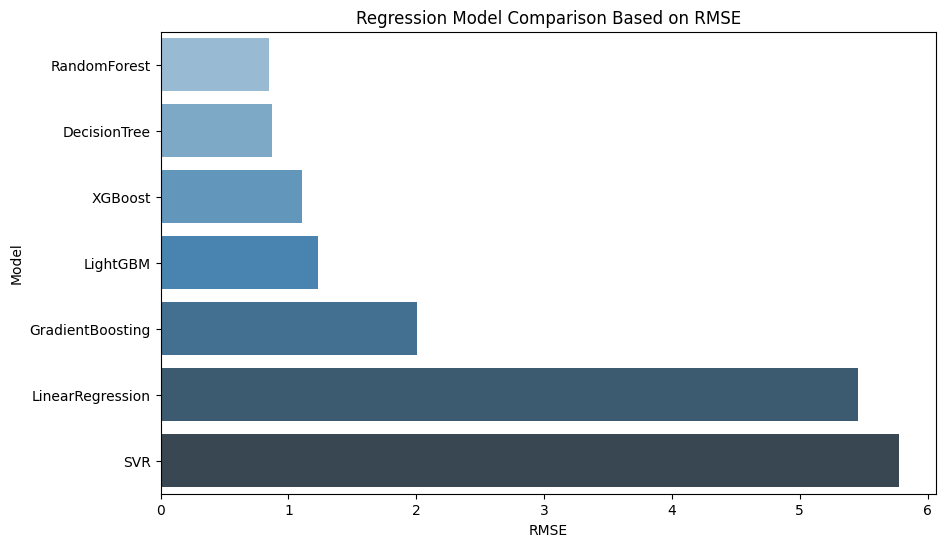

In [38]:
# ==========================================
# Cell 14: Compare All Regression Models
# ==========================================

model_results = {
    'Model': [
        'LinearRegression', 
        'DecisionTree', 
        'RandomForest', 
        'GradientBoosting',
        'XGBoost', 
        'LightGBM', 
        'SVR'
    ],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_gb, rmse_xgb, rmse_lgbm, rmse_svr],
    'MAE': [mae_lr, mae_dt, mae_rf, mae_gb, mae_xgb, mae_lgbm, mae_svr],
    'R2':  [r2_lr, r2_dt, r2_rf, r2_gb, r2_xgb, r2_lgbm, r2_svr]
}

results_df = pd.DataFrame(model_results)
results_df.sort_values(by='RMSE', ascending=True, inplace=True)
print("=== Model Comparison (Regression) ===")
print(results_df)

# Visualize comparison by RMSE
plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='Blues_d', dodge=False)
plt.title("Regression Model Comparison Based on RMSE")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.show()


Ta sẽ phân loại biến `CO2_pc` thành ba mức bằng hàm pd.qcut:
- Low
- Medium
- High

Sau đó, chuẩn bị X_class, y_class để train mô hình Classification.


In [39]:
# =======================================================
# Cell 15: Classification - Binning CO2_pc into 3 Classes
# =======================================================

# Create a 'co2_category' column by splitting CO2_pc into 3 quantiles: Low, Medium, High
df['co2_category'] = pd.qcut(df['CO2_pc'], q=3, labels=['Low','Medium','High'])

# Define features and target for classification
X_class = df[feature_columns].copy()
y_class = df['co2_category'].copy()

# Train/Test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Scale features
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)


Chúng ta sẽ thử:
- LogisticRegression
- DecisionTree
- RandomForest
- GradientBoosting
- SVM

và tính Accuracy. Ngoài ra, ta in classification_report, confusion_matrix để đánh giá chi tiết hơn.


In [40]:
# ====================================
# Cell 16: Train Multiple Classifiers
# ====================================

classification_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC()
}

classification_scores = {}

for name, model in classification_models.items():
    model.fit(X_train_class_scaled, y_train_class)
    y_pred_class = model.predict(X_test_class_scaled)
    acc = accuracy_score(y_test_class, y_pred_class)
    classification_scores[name] = acc
    
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_class, y_pred_class))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class))
    print("-"*50)


=== LogisticRegression ===
Accuracy: 0.5868
Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.51      0.63       194
         Low       0.50      0.97      0.66       190
      Medium       0.67      0.26      0.38       175

    accuracy                           0.59       559
   macro avg       0.66      0.58      0.55       559
weighted avg       0.66      0.59      0.56       559

Confusion Matrix:
[[ 98  79  17]
 [  0 184   6]
 [ 21 108  46]]
--------------------------------------------------
=== DecisionTree ===
Accuracy: 0.9338
Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.93      0.95       194
         Low       0.97      0.93      0.95       190
      Medium       0.87      0.94      0.91       175

    accuracy                           0.93       559
   macro avg       0.93      0.93      0.93       559
weighted avg       0.94      0.93      0.93       

Ta sẽ vẽ barplot so sánh độ chính xác (Accuracy) của các mô hình phân loại.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17252\560143702.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='viridis')


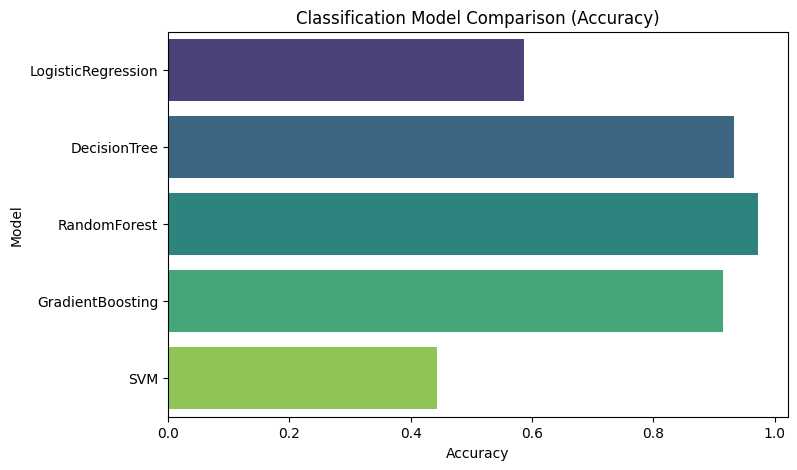

Classification accuracies: {'LogisticRegression': 0.5867620751341681, 'DecisionTree': 0.9338103756708408, 'RandomForest': 0.9731663685152058, 'GradientBoosting': 0.9141323792486583, 'SVM': 0.44364937388193204}


In [41]:
# ==============================================
# Cell 17: Visualize Classification Accuracies
# ==============================================

plt.figure(figsize=(8,5))
model_names = list(classification_scores.keys())
accuracies = list(classification_scores.values())

sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.title("Classification Model Comparison (Accuracy)")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

print("Classification accuracies:", classification_scores)


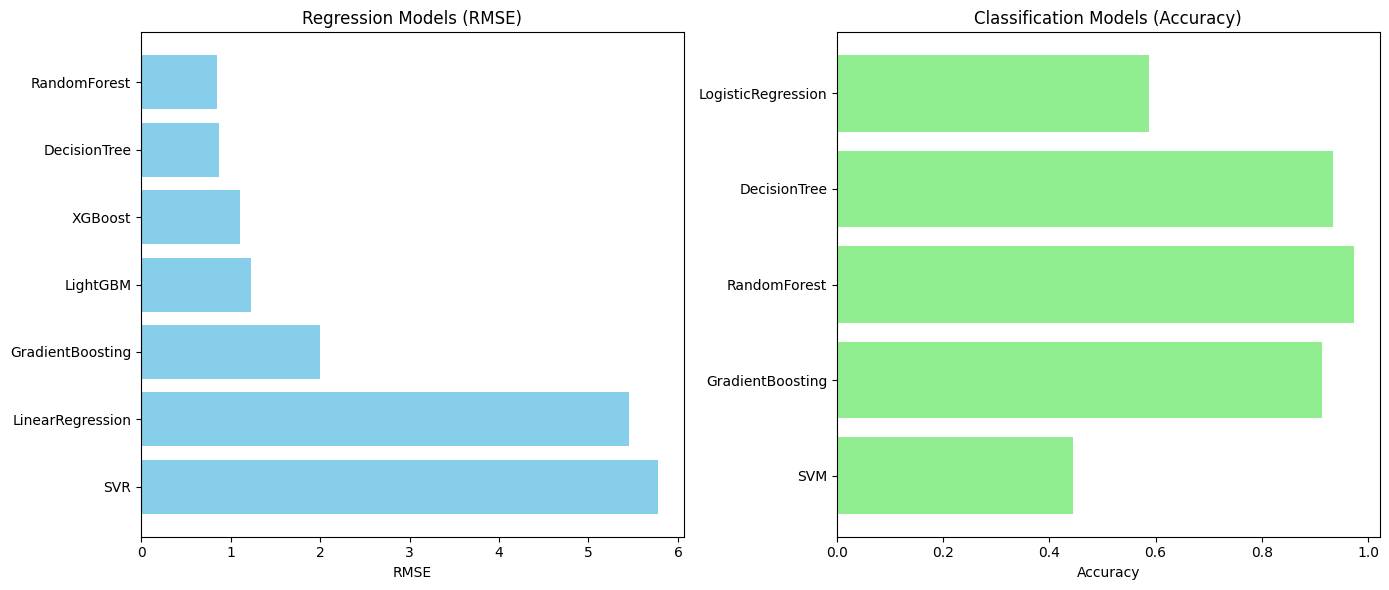

In [42]:
# ===========================
# Cell 36: Tổng hợp Visual
# ===========================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Biểu đồ so sánh RMSE của các mô hình Regression ---
axes[0].barh(
    results_df['Model'], 
    results_df['RMSE'], 
    color='skyblue'
)
axes[0].set_title("Regression Models (RMSE)")
axes[0].set_xlabel("RMSE")
axes[0].invert_yaxis()  # Đảo chiều trục Y để Model hiển thị trên cao

# --- Biểu đồ so sánh Accuracy của các mô hình Classification ---
class_model_names = list(classification_scores.keys())
class_accuracies = list(classification_scores.values())

axes[1].barh(
    class_model_names, 
    class_accuracies, 
    color='lightgreen'
)
axes[1].set_title("Classification Models (Accuracy)")
axes[1].set_xlabel("Accuracy")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


**Đánh giá Kết quả:**

- **Regression (Biểu đồ bên trái, chỉ số RMSE thấp hơn là tốt hơn)**  
  - **RandomForest** có RMSE thấp nhất, cho thấy năng lực dự đoán CO₂ trên đầu người tốt nhất trong nhóm mô hình so sánh.  
  - Kế tiếp có thể kể đến DecisionTree và XGBoost với RMSE nhỉnh hơn một chút.  
  - **SVR** và **LinearRegression** có RMSE cao hơn, nghĩa là dự đoán kém chính xác hơn so với các mô hình còn lại.  

- **Classification (Biểu đồ bên phải, chỉ số Accuracy cao hơn là tốt hơn)**  
  - **DecisionTree** đạt Accuracy cao nhất, chứng tỏ phân loại dữ liệu (Low–Medium–High) hiệu quả nhất trong danh sách.  
  - Tiếp theo là GradientBoosting, RandomForest, LogisticRegression, và **SVM** có độ chính xác thấp nhất.  

Tổng thể, nếu cần mô hình **Regression** để dự đoán CO₂ trên đầu người, **RandomForest** là lựa chọn hàng đầu. Trong khi đó, nếu cần **Classification** để phân nhóm (Low–Medium–High), **DecisionTree** đem lại độ chính xác cao nhất trong biểu đồ so sánh này.
